# 1. Load and Read Data

In [9]:
import pandas as pd

# Load the uploaded CSV files
historical_data_path = "../data/historical_data.csv"
fear_greed_index_path = "../data/fear_greed_index.csv"

# Read the CSV files into DataFrames
historical_df = pd.read_csv(historical_data_path)
fear_greed_df = pd.read_csv(fear_greed_index_path)

# Show the first few rows of each dataset
historical_df.head(), fear_greed_df.head()


(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
 4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0      

# Step 2: Preprocessing Historical Trader Data

In [46]:
# Convert 'Timestamp IST' to datetime format
historical_df['date'] = pd.to_datetime(historical_df['Timestamp IST'], format='%d-%m-%Y %H:%M')

# Extract only date part for merging
historical_df['date_only'] = historical_df['date'].dt.date

# Clean and convert 'Closed PnL' to numeric
historical_df['Closed PnL'] = pd.to_numeric(historical_df['Closed PnL'], errors='coerce')

# Grouping by date to summarize key metrics per day
daily_summary = historical_df.groupby('date_only').agg({
    'Closed PnL': ['mean', 'sum'],
    'Side': lambda x: (x == 'BUY').sum() / len(x),  # Buy ratio
    'Execution Price': 'mean',
    'Size USD': 'sum',
    'Account': pd.Series.nunique
}).reset_index()

# Rename columns
daily_summary.columns = ['date', 'avg_pnl', 'total_pnl', 'buy_ratio', 'avg_price', 'total_volume_usd', 'unique_traders']

daily_summary.to_csv('../data/daily_summary.csv', index=True)

# Check the summary
daily_summary.head()

,date,avg_pnl,total_pnl,buy_ratio,avg_price,total_volume_usd,unique_traders
0,2023-05-01,0.000000,0.000000,1.000000,1898.133333,477.00,1
1,2023-12-05,0.000000,0.000000,0.777778,11038.300000,50005.83,1
2,2023-12-14,-18.675885,-205.434737,0.454545,8031.868818,113203.35,1
3,2023-12-15,-12.316017,-24.632034,1.000000,2.982000,10609.95,1
4,2023-12-16,0.000000,0.000000,1.000000,0.384707,15348.77,1


# Step 3: Preprocessing Fear/Greed Index and Merging

In [47]:
# Convert the 'date' column in fear_greed_df to datetime.date format
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date']).dt.date

# Select only necessary columns
fear_greed_clean = fear_greed_df[['date', 'value', 'classification']]
fear_greed_clean.rename(columns={'value': 'sentiment_score', 'classification': 'sentiment_label'}, inplace=True)

# Merge with the historical daily summary on date
daily_df = pd.merge(daily_summary, fear_greed_clean, on='date', how='inner')

daily_df.to_csv('../data/daily_summary.csv', index=True)

# Check the merged result
daily_df.head()


/var/folders/7f/yq3zd3_94cbcknly7f883cs40000gn/T/ipykernel_28670/1234665714.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fear_greed_clean.rename(columns={'value': 'sentiment_score', 'classification': 'sentiment_label'}, inplace=True)


,date,avg_pnl,total_pnl,buy_ratio,avg_price,total_volume_usd,unique_traders,sentiment_score,sentiment_label
0,2023-05-01,0.000000,0.000000,1.000000,1898.133333,477.00,1,63,Greed
1,2023-12-05,0.000000,0.000000,0.777778,11038.300000,50005.83,1,75,Extreme Greed
2,2023-12-14,-18.675885,-205.434737,0.454545,8031.868818,113203.35,1,72,Greed
3,2023-12-15,-12.316017,-24.632034,1.000000,2.982000,10609.95,1,70,Greed
4,2023-12-16,0.000000,0.000000,1.000000,0.384707,15348.77,1,67,Greed


# Exploratory Data Analysis (EDA)

# Step 4. Total PnL Across Sentiment Labels

/var/folders/7f/yq3zd3_94cbcknly7f883cs40000gn/T/ipykernel_28670/634433823.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=daily_df, x='sentiment_label', y='total_pnl', palette='coolwarm')


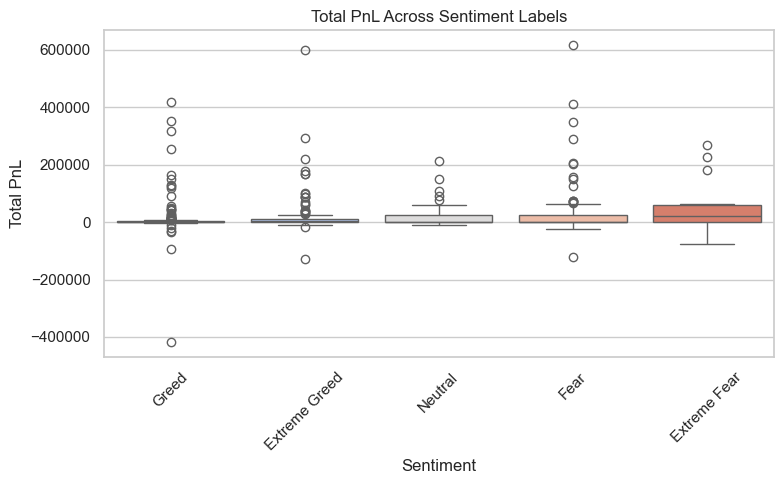

In [23]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=daily_df, x='sentiment_label', y='total_pnl', palette='coolwarm')
plt.title("Total PnL Across Sentiment Labels")
plt.ylabel("Total PnL")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Step 5. Buy Ratio Across Sentiment Labels


/var/folders/7f/yq3zd3_94cbcknly7f883cs40000gn/T/ipykernel_28670/485700096.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=daily_df, x='sentiment_label', y='buy_ratio', palette='viridis')


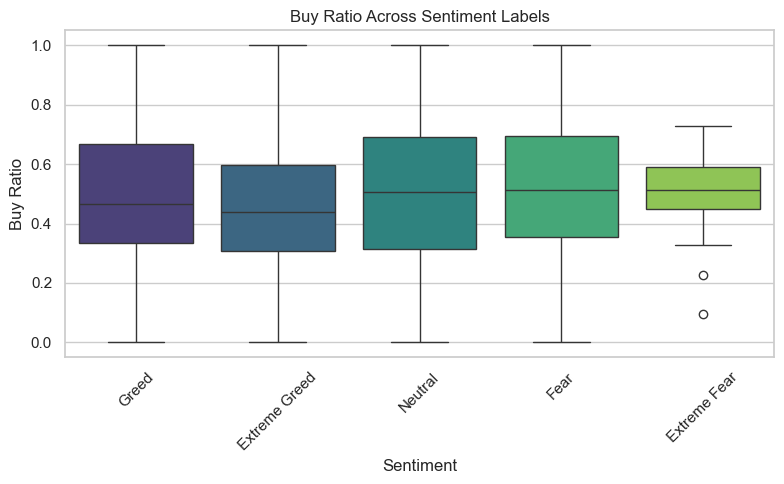

In [24]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=daily_df, x='sentiment_label', y='buy_ratio', palette='viridis')
plt.title("Buy Ratio Across Sentiment Labels")
plt.ylabel("Buy Ratio")
plt.xlabel("Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Step 6. Correlation Heatmap


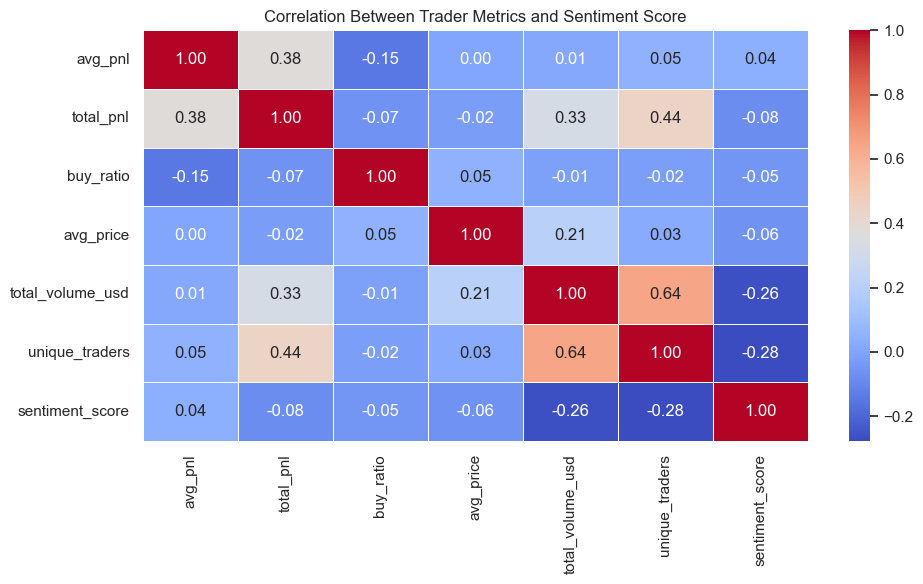

In [26]:
corr_cols = ['avg_pnl', 'total_pnl', 'buy_ratio', 'avg_price', 'total_volume_usd', 'unique_traders', 'sentiment_score']
corr_matrix = daily_df[corr_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Trader Metrics and Sentiment Score")
plt.tight_layout()
plt.show()


# Step 7. Time Series Plot of PnL and Volume

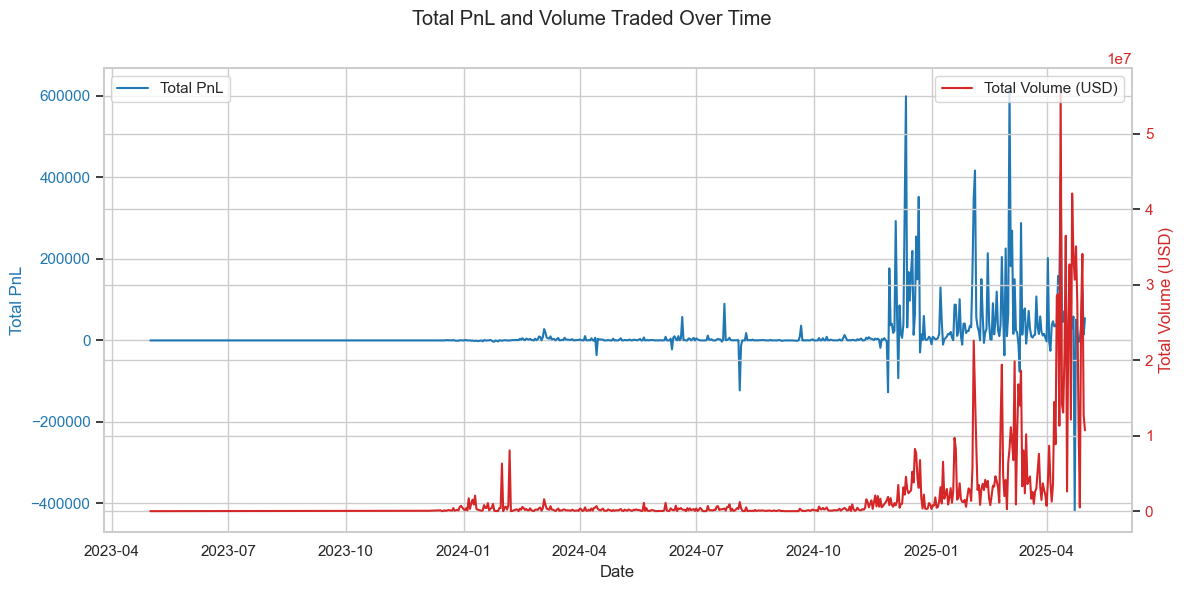

In [29]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Total PnL', color=color)
ax1.plot(daily_df['date'], daily_df['total_pnl'], color=color, label='Total PnL')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Total Volume (USD)', color=color)
ax2.plot(daily_df['date'], daily_df['total_volume_usd'], color=color, label='Total Volume (USD)')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

fig.suptitle('Total PnL and Volume Traded Over Time')
plt.tight_layout()
plt.show()


# Step 8. Sentiment Distribution

/var/folders/7f/yq3zd3_94cbcknly7f883cs40000gn/T/ipykernel_28670/2945288760.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=daily_df, x='sentiment_label', palette='Set2',


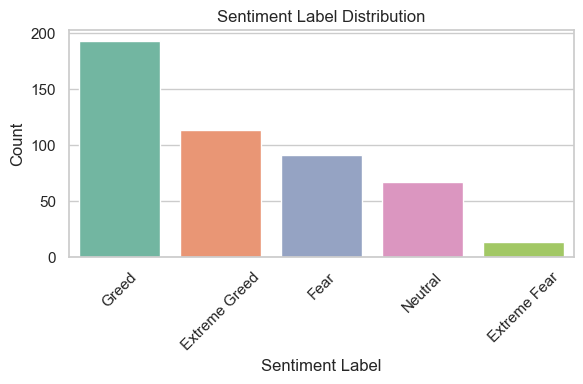

In [31]:
plt.figure(figsize=(6, 4))
sns.countplot(data=daily_df, x='sentiment_label', palette='Set2',
              order=daily_df['sentiment_label'].value_counts().index)
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Step 9. Sentiment Shift Impact Analysis

In [36]:
daily_df['prev_sentiment'] = daily_df['sentiment_label'].shift(1)
daily_df['sentiment_shift'] = daily_df['sentiment_label'] != daily_df['prev_sentiment']
shift_analysis = daily_df.groupby('sentiment_shift').agg({
    'total_pnl': ['mean', 'std'],
    'buy_ratio': 'mean',
    'total_volume_usd': 'mean'
}).reset_index()
shift_analysis.columns = ['sentiment_shift', 'avg_pnl', 'pnl_std', 'avg_buy_ratio', 'avg_volume_usd']
print(shift_analysis)


   sentiment_shift       avg_pnl       pnl_std  avg_buy_ratio  avg_volume_usd
0            False  17581.523705  60041.625852       0.487936    2.110739e+06
1             True  31573.409923  96220.119800       0.492694    3.485203e+06


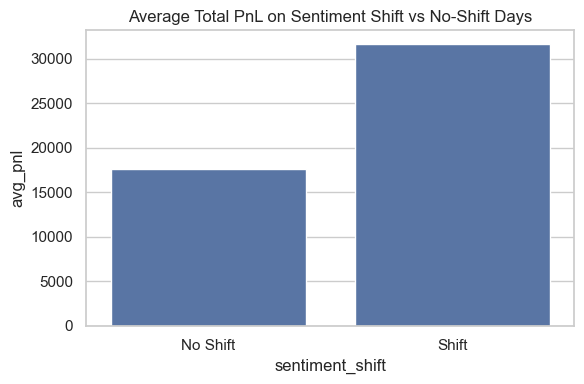

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.barplot(data=shift_analysis, x='sentiment_shift', y='avg_pnl')
plt.title("Average Total PnL on Sentiment Shift vs No-Shift Days")
plt.xticks([0, 1], ["No Shift", "Shift"])
plt.tight_layout()
plt.show()


# Step 10. Market Mood Clustering (Unsupervised ML)

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

cluster_features = daily_df[['buy_ratio', 'total_pnl', 'sentiment_score', 'total_volume_usd']].fillna(0)
scaler = StandardScaler()
scaled = scaler.fit_transform(cluster_features)

kmeans = KMeans(n_clusters=3, random_state=42)
daily_df['mood_cluster'] = kmeans.fit_predict(scaled)


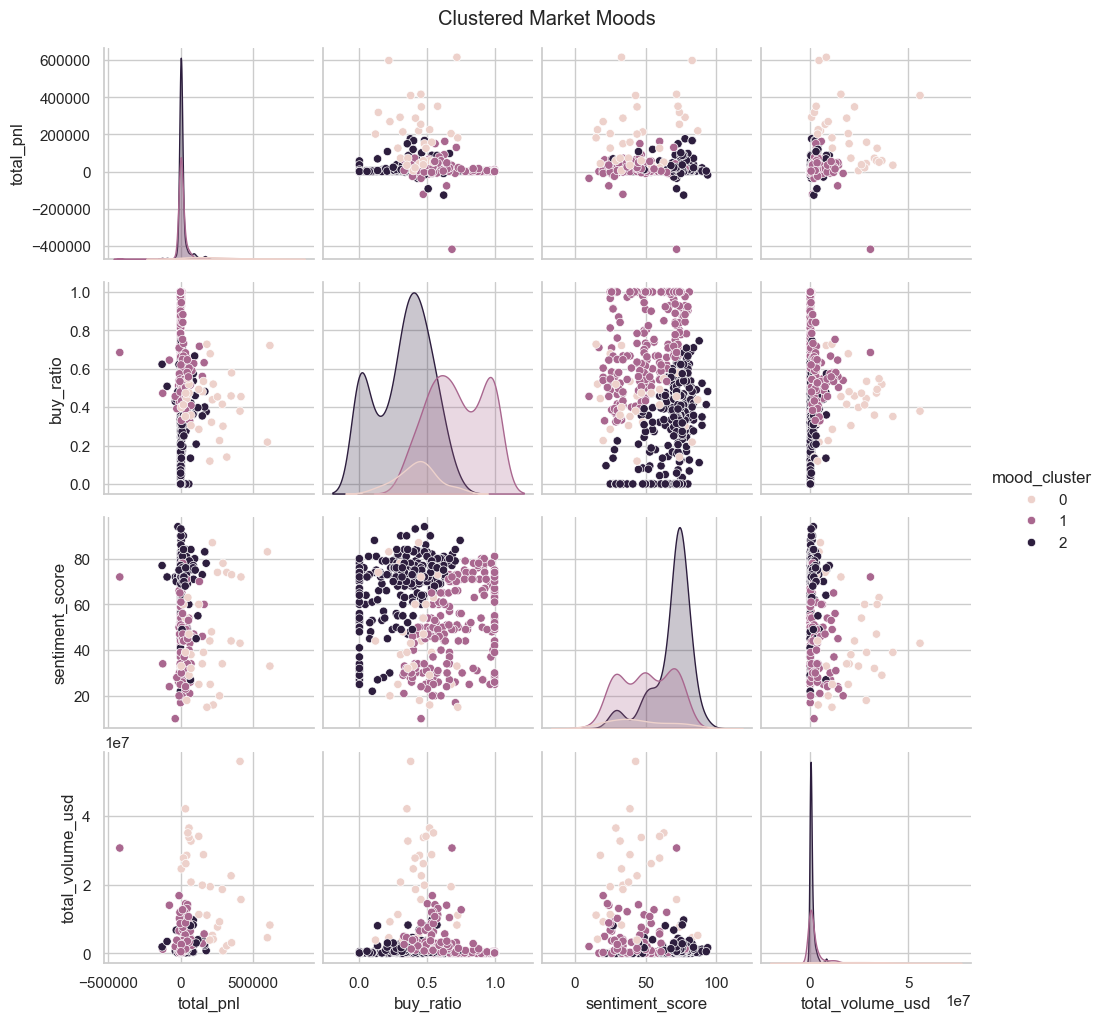

In [ ]:
sns.pairplot(daily_df, hue='mood_cluster', vars=['total_pnl', 'buy_ratio', 'sentiment_score', 'total_volume_usd'])
plt.suptitle("Clustered Market Moods", y=1.02)
plt.show()

In [42]:
daily_df.groupby('mood_cluster').agg({
    'total_pnl': 'mean',
    'buy_ratio': 'mean',
    'sentiment_score': 'mean',
    'total_volume_usd': 'mean'
})


,total_pnl,buy_ratio,sentiment_score,total_volume_usd
mood_cluster,,,,
0,207382.412701,0.426688,46.258065,1.929864e+07
1,6847.498327,0.721970,50.523560,2.004193e+06
2,9796.731421,0.323817,68.801556,8.172765e+05


# Step 11. Daily Profit Prediction (Classifier)


In [43]:
daily_df['profitable_day'] = (daily_df['total_pnl'] > 0).astype(int)

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = daily_df[['buy_ratio', 'sentiment_score', 'total_volume_usd']]
y = daily_df['profitable_day']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           0       0.58      0.35      0.44        20
           1       0.85      0.93      0.89        76

    accuracy                           0.81        96
   macro avg       0.71      0.64      0.66        96
weighted avg       0.79      0.81      0.79        96

